In [4]:
!pip install --no-cache-dir torch torchvision torchaudio -q
!pip install --no-cache-dir pytorch-lightning -q
!pip install --no-cache-dir custatevec-cu12 -q
!pip install --no-cache-dir lightning pennylane-lightning-gpu -q
!pip install --no-cache-dir pandas matplotlib geoopt -q
!pip install --no-cache-dir "jax[cuda12]" pennylane-catalyst -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 187.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.7/647.7 MB 212.5 MB/s eta 0:00:0000:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.16.0.29 which is incompatible.


100%|██████████| 6/6 [00:00<00:00, 64.92it/s]


Geometry-guided avg success: 1.3202997165051747e+28
Naive baseline avg success: 0.4125000000000001


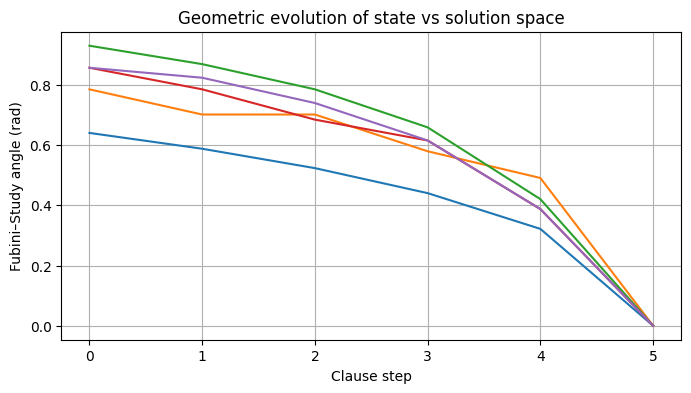

In [5]:
# Geometry-Guided Quantum SAT Solver

import numpy as np
import torch
import geoopt
from typing import List, Tuple
import itertools
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# Clause type and utilities
Clause = List[Tuple[int, bool]]
Formula = List[Clause]

def generate_random_3sat(n_vars: int, n_clauses: int) -> Formula:
    formula = []
    for _ in range(n_clauses):
        clause_vars = np.random.choice(n_vars, 3, replace=False)
        clause = [(int(v), bool(np.random.randint(2))) for v in clause_vars]
        formula.append(clause)
    return formula

def eval_clause(bits: Tuple[int], clause: Clause) -> bool:
    return any((bits[v] ^ is_neg) for v, is_neg in clause)

def basis_states(n: int) -> List[Tuple[int]]:
    return list(itertools.product([0, 1], repeat=n))

# Clause projector in computational basis

def clause_projector(n: int, clause: Clause) -> torch.Tensor:
    dim = 2 ** n
    P = torch.zeros((dim, dim), dtype=torch.cdouble)
    for i, bits in enumerate(basis_states(n)):
        if eval_clause(bits, clause):
            P[i, i] = 1.0
    return P

def full_solution_projector(n: int, formula: Formula) -> torch.Tensor:
    dim = 2 ** n
    P = torch.zeros((dim, dim), dtype=torch.cdouble)
    for i, bits in enumerate(basis_states(n)):
        if all(eval_clause(bits, c) for c in formula):
            P[i, i] = 1.0
    return P

def fubini_study_angle(psi: torch.Tensor, phi: torch.Tensor) -> float:
    overlap = torch.abs(torch.vdot(psi, phi))
    return float(torch.acos(torch.clamp(overlap, 0.0, 1.0)))

# Geometry-guided unitary optimization on St(d,d)

def optimize_unitary_stiefel(psi: torch.Tensor, P: torch.Tensor, 
                              lr=0.1, steps=100) -> Tuple[torch.Tensor, List[float]]:
    d = psi.shape[0]
    manifold = geoopt.manifolds.Stiefel()
    U = geoopt.ManifoldParameter(torch.eye(d, dtype=torch.cdouble), manifold=manifold)
    optimizer = torch.optim.SGD([U], lr=lr)
    overlaps = []

    for _ in range(steps):
        optimizer.zero_grad()
        UHU = U.conj().T @ P @ U
        overlap = torch.vdot(psi, UHU @ psi).real
        loss = -overlap
        loss.backward()
        optimizer.step()
        overlaps.append(overlap.item())

    return U.detach(), overlaps

# Measurement and projection

def project_and_normalize(psi: torch.Tensor, P: torch.Tensor) -> Tuple[torch.Tensor, float]:
    p = torch.vdot(psi, P @ psi).real.item()
    if p < 1e-12:
        return psi, 0.0
    psi_proj = P @ psi / torch.sqrt(torch.tensor(p, dtype=torch.float64))
    return psi_proj, p

# Solver loop

def geometry_guided_solver(n: int, formula: Formula, steps=50, lr=0.1, verbose=False):
    dim = 2 ** n
    psi = torch.ones(dim, dtype=torch.cdouble) / math.sqrt(dim)
    projectors = [clause_projector(n, c) for c in formula]
    P_solution = full_solution_projector(n, formula)

    total_p = 1.0
    fs_angles = []

    for P in tqdm(projectors):
        U, _ = optimize_unitary_stiefel(psi, P, lr=lr, steps=steps)
        psi_rot = U @ psi
        psi, p_clause = project_and_normalize(psi_rot, P)
        total_p *= p_clause
        fs_angle = fubini_study_angle(psi, (P_solution @ psi) / torch.linalg.norm(P_solution @ psi))
        fs_angles.append(fs_angle)
        if verbose:
            print(f"Clause success: {p_clause:.6f}, Fubini–Study angle: {fs_angle:.4f} rad")
        if p_clause < 1e-6:
            break

    return {
        "final_state": psi,
        "success_prob": total_p,
        "fubini_angles": fs_angles,
        "overlap_solution": torch.vdot(psi, P_solution @ psi).real.item()
    }

# Time-to-solution

def time_to_solution(p_success: float, t_run: float, p_target=0.99) -> float:
    if p_success <= 0.0:
        return float("inf")
    if p_success >= 1.0:
        return t_run
    num_runs = math.log(1 - p_target) / math.log(1 - p_success)
    return t_run * num_runs

# Baselines (naive + classical)
def naive_measurement_solver(n: int, formula: Formula):
    dim = 2 ** n
    psi = torch.ones(dim, dtype=torch.cdouble) / math.sqrt(dim)
    total_p = 1.0
    for clause in formula:
        P = clause_projector(n, clause)
        p_clause = torch.vdot(psi, P @ psi).real.item()
        psi, _ = project_and_normalize(psi, P)
        total_p *= p_clause
    return total_p

# Benchmarking setup
def benchmark_experiment(n: int, m: int, trials=10):
    geo_scores = []
    naive_scores = []
    fs_logs = []
    for _ in range(trials):
        formula = generate_random_3sat(n, m)
        res = geometry_guided_solver(n, formula, steps=30, lr=0.1)
        geo_scores.append(res["success_prob"])
        fs_logs.append(res["fubini_angles"])
        naive = naive_measurement_solver(n, formula)
        naive_scores.append(naive)

    print("Geometry-guided avg success:", np.mean(geo_scores))
    print("Naive baseline avg success:", np.mean(naive_scores))
    return geo_scores, naive_scores, fs_logs

# Example driver
if __name__ == "__main__":
    n = 4
    m = 6
    geo_scores, naive_scores, fs_logs = benchmark_experiment(n, m, trials=5)

    plt.figure(figsize=(8, 4))
    for angles in fs_logs:
        plt.plot(angles, label='Fubini–Study angle')
    plt.xlabel("Clause step")
    plt.ylabel("Fubini–Study angle (rad)")
    plt.title("Geometric evolution of state vs solution space")
    plt.grid()
    plt.show()